In [1]:
!pip install -Uqq git+https://github.com/jaysinghr/DL-to-Diffusion@develop

In [1]:
#|default_exp init

# Initialization

In [3]:
#|export
import pickle, gzip, math, os, time, shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys,gc,traceback
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

import fastcore.all as fc
from minimalai.datasets import *
from minimalai.conv import *
from minimalai.learner import *
from minimalai.activations import *

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [5]:
# Define the keys for image and label
image_key, label_key = 'image', 'label'
# Specify the name of the dataset (e.g., "fashion_mnist")
dataset_name = "fashion_mnist"

# Load the dataset using the specified name
dataset_dict = load_dataset(dataset_name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# Define the function to transform the data inplace
@apply_inplace_transformation
def transform_images_inplace(batch):
    """
    Transform the images in the batch to tensors and flatten them inplace.

    Args:
    - batch (dict): A dictionary containing the batch of data.

    Returns:
    - dict: The transformed batch with images flattened as tensors.
    """
    batch[image_key] = [TF.to_tensor(image) for image in batch[image_key]]
    return batch

In [7]:
# Define the batch size for the data loader
batch_size = 1024

# Apply the transform function `transform_images_inplace` to the dataset `loaded_dataset`
transformed_dataset = dataset_dict.with_transform(transform_images_inplace)

# Create data loaders from the transformed dataset `transformed_dataset` with the specified batch size `batch_size` and number of workers `num_workers`
data_loaders = DataLoaders.from_dataset_dict(transformed_dataset, batch_size, num_workers=4)

# Get the training data loader from the created data loaders
train_data_loader = data_loaders.train_loader

# Get a batch of data from the training data loader
inputs_batch, labels_batch = next(iter(train_data_loader))

# Print the shape of the input batch and the first 10 labels
print("Input Batch Shape:", inputs_batch.shape)
print("First 10 Labels:", labels_batch[:10])

Input Batch Shape: torch.Size([1024, 1, 28, 28])
First 10 Labels: tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1])


In [8]:
def create_cnn_model():
    return nn.Sequential(
        conv_layer(1, 8),       # 14x14
        conv_layer(8, 16),      # 7x7
        conv_layer(16, 32),     # 4x4
        conv_layer(32, 64),     # 2x2
        conv_layer(64, 10, apply_activation=False),  # 1x1
        nn.Flatten()
    ).to(default_device)

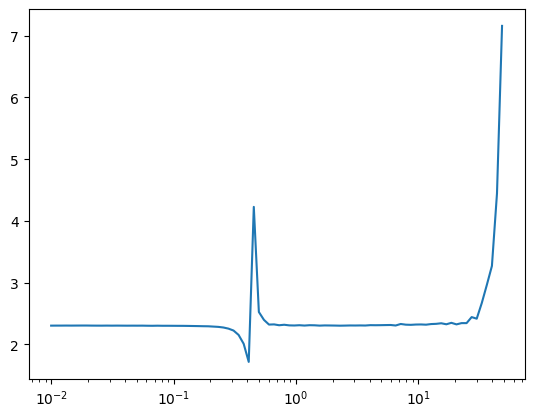

In [9]:
MomentumLearner(create_cnn_model(), 
                data_loaders, 
                F.cross_entropy, 
                callbacks=[DeviceCallback()]).find_lr(lr_multiplier=1.1, start_lr=1e-2)

In [10]:
metrics = MetricsCallback(accuracy=MulticlassAccuracy())
astats = ActivationStatisticsCallback(fc.risinstance(nn.ReLU))
cbs = [DeviceCallback(), metrics, ProgressCallback(plot=True), astats]


learn = MomentumLearner(create_cnn_model(), 
                        data_loaders, 
                        F.cross_entropy, 
                        learning_rate=0.2, 
                        callbacks=cbs)

accuracy,loss,epoch,train
0.253,2.047,0,train
0.594,1.071,0,eval


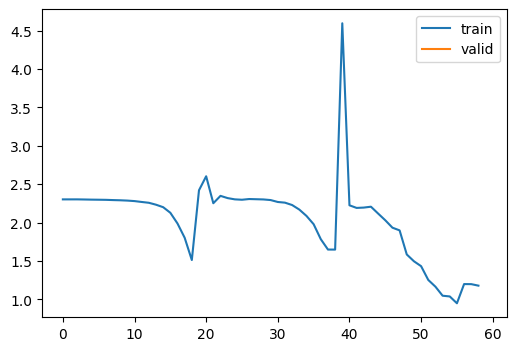

In [11]:
learn.fit(1)

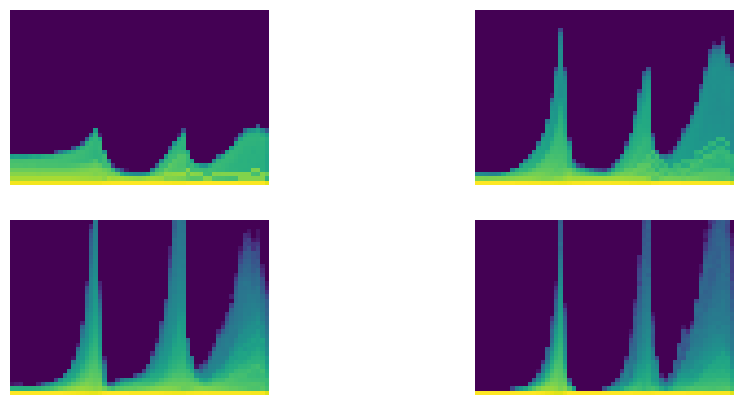

In [12]:
astats.plot_color_dimensions()

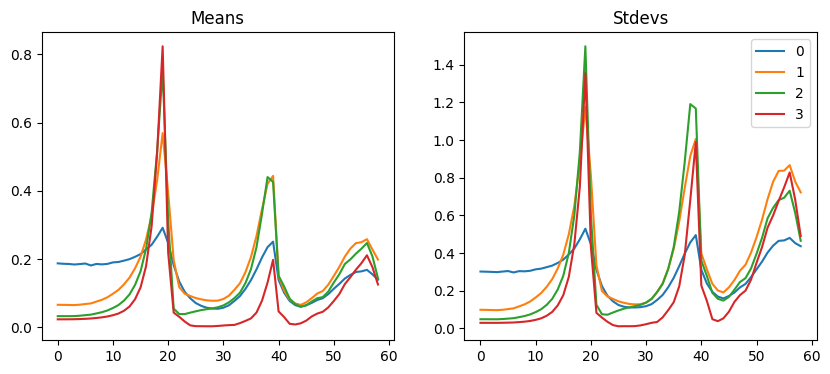

In [13]:
astats.plot_activation_stats()

In [14]:
#|export
def clean_ipython_history():
    # Code in this function mainly copied from IPython source
    if 'get_ipython' not in globals():
        return
    
    ipython_instance = get_ipython()
    user_namespace = ipython_instance.user_ns
    ipython_instance.displayhook.flush()
    prompt_count = ipython_instance.displayhook.prompt_count + 1
    for i in range(1, prompt_count):
        user_namespace.pop(f'_i{i}', None)
    user_namespace.update({'_i': '', '_ii': '', '_iii': ''})
    history_manager = ipython_instance.history_manager
    history_manager.input_hist_parsed[:] = [''] * prompt_count
    history_manager.input_hist_raw[:] = [''] * prompt_count
    history_manager._i = history_manager._ii = history_manager._iii = history_manager._i00 = ''

In [15]:
#|export
def clean_traceback():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'):
        delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'):
        delattr(sys, 'last_value')

In [16]:
#|export
def clean_memory():
    clean_traceback()
    clean_ipython_history()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier init

In [17]:
# Initialize a tensor of size (200, 100) with random values
input_tensor = torch.randn(200, 100)

# Perform 50 matrix multiplications
for i in range(50):
    # Multiply the tensor with a randomly initialized matrix of size (100, 100)
    input_tensor = input_tensor @ torch.randn(100, 100)

# Print the top-left 5x5 submatrix of the resulting tensor
print(input_tensor[0:5, 0:5])

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])


The result is `nan`s everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem—the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:

In [19]:
# Initialize a tensor of size (200, 100) with random values
input_tensor = torch.randn(200, 100)

# Perform 50 matrix multiplications
for i in range(50):
    # Multiply the tensor with a randomly initialized matrix of size (100, 100) scaled by 0.01
    input_tensor = input_tensor @ (torch.randn(100, 100) * 0.01)

# Print the top-left 5x5 submatrix of the resulting tensor
print(input_tensor[0:5, 0:5])

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

In [20]:
# Initialize a tensor of size (200, 100) with random values
input_tensor = torch.randn(200, 100)

# Perform 50 matrix multiplications with random tensors of size (100, 100) scaled by 0.1
for i in range(50):
    # Multiply the tensor with a randomly initialized matrix of size (100, 100) scaled by 0.1
    input_tensor = input_tensor @ (torch.randn(100, 100) * 0.1)

# Print the top-left 5x5 submatrix of the resulting tensor
print(input_tensor[0:5, 0:5])

tensor([[ 0.23,  0.84,  0.73,  1.20, -1.15],
        [-2.02, -0.44, -0.03, -0.69,  0.36],
        [ 0.23,  0.48,  0.94,  1.40, -0.74],
        [ 1.88, -0.07, -1.19, -0.41,  0.66],
        [-0.78,  0.59, -0.57, -0.24,  0.05]])


### Background

### Variance and standard deviation

Variance is the average of how far away each data point is from the mean. E.g.:

In [21]:
# Initialize a tensor with the values [1., 2., 4., 18.]
t = torch.tensor([1., 2., 4., 18.])

In [22]:
m = t.mean()
print(m)

tensor(6.25)


In [23]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [24]:
(t-m).pow(2).mean()

tensor(47.19)

In [25]:
(t-m).abs().mean()

tensor(5.88)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [26]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

The standard deviation represents if the data stays close to the mean or on the contrary gets values that are far away. It's computed by the following formula:

$$\sigma = \sqrt{\frac{1}{n}\left[(x_{0}-m)^{2} + (x_{1}-m)^{2} + \cdots + (x_{n-1}-m)^{2}\right]}$$

where m is the mean and $\sigma$ (the greek letter sigma) is the standard deviation. Here we have a mean of 0, so it's just the square root of the mean of x squared.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [27]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

Let's see that in code. So now we need two vectors.

In [28]:
t

tensor([ 1.,  2.,  4., 18.])

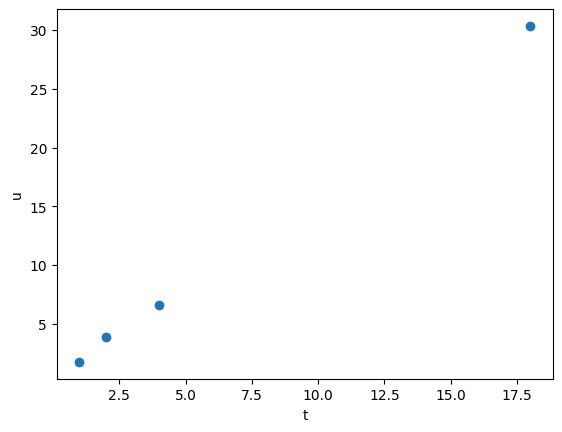

In [29]:
# `u` is twice `t`, plus a bit of randomness
u = t * 2
u *= torch.randn_like(t) / 10 + 0.95

plt.scatter(t, u)
plt.xlabel('t')
plt.ylabel('u')
plt.show()

In [30]:
centered_product = (t - t.mean()) * (u - u.mean())
centered_product

tensor([ 46.69,  28.72,   9.17, 231.80])

In [31]:
centered_product.mean()

tensor(79.09)

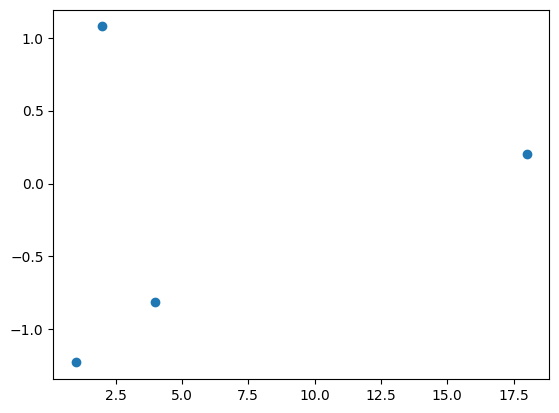

In [32]:
random_values = torch.randn_like(t)
plt.scatter(t, random_values)

In [34]:
((t - t.mean()) * (random_values - random_values.mean())).mean()

tensor(1.51)

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [35]:
cov = (t * random_values).mean() - t.mean() * random_values.mean()
cov

tensor(1.51)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [36]:
cov / (t.std() * random_values.std())

tensor(0.18)

It's just a scaled version of the same thing.

In [37]:
input_tensor.std()

tensor(0.74)

### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in pure python code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

or in numpy/pytorch code:
```
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

In [38]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(-0.09), tensor(0.94))

If we go back to `y = a @ x` and assume that we chose weights for `a` that also have a mean of 0, we can compute the standard deviation of `y` quite easily. Since it's random, and we may fall on bad numbers, we repeat the operation 100 times.

In [39]:
# Calculate the mean and squared mean of 100 random vector-matrix products
mean_sum, sqr_sum = 0., 0.

for _ in range(100):
    # Generate a random vector
    x = torch.randn(100)
    
    # Generate a random matrix
    a = torch.randn(512, 100)
    
    # Calculate the vector-matrix product
    y = a @ x
    
    # Accumulate the mean and squared mean of the products
    mean_sum += y.mean().item()
    sqr_sum += y.pow(2).mean().item()

# Calculate the average mean and squared mean
average_mean = mean_sum / 100
average_sqr = sqr_sum / 100

# Print the results
average_mean, average_sqr

(0.024091255143284796, 100.60629844665527)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of a by one element of x. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in `a` and the elements in `x` are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [40]:
# Calculate the mean and squared mean of 100 random vector-matrix products
mean_sum, sqr_sum = 0., 0.

for _ in range(10000):
    # Generate a random vector
    x = torch.randn(1)
    
    # Generate a random matrix
    a = torch.randn(1)
    
    # Calculate the vector-matrix product
    y = a @ x
    
    # Accumulate the mean and squared mean of the products
    mean_sum += y.item()
    sqr_sum += y.pow(2).item()

# Calculate the average mean and squared mean
average_mean = mean_sum / 10000
average_sqr = sqr_sum / 10000

# Print the results
average_mean, average_sqr

(-0.0021617031913853226, 1.0304749903293884)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence `math.sqrt(100)` being our magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a `y` of scale 1, and repeating the product has many times as we want won't overflow or vanish.

## Kaiming/He init

("He" is a Chinese surname and is pronouced like "Her", not like "Hee".)

### Background

In [41]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [42]:
from math import sqrt

In [43]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [46]:
def lin(x, w, b):
    return x @ w + b

In [47]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(-0.00), tensor(1.01))

In [48]:
def relu(x):
    return x.clamp_min(0.)

In [49]:
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.40), tensor(0.59))

In [50]:
x = torch.randn(200, 100)
for i in range(50):
    x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.

In [51]:
x = torch.randn(200, 100)
for i in range(50):
    x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.00, 0.19, 0.00, 0.63, 0.00],
        [0.00, 0.09, 0.00, 0.24, 0.00],
        [0.00, 0.11, 0.00, 0.46, 0.00],
        [0.00, 0.20, 0.00, 0.32, 0.00],
        [0.00, 0.08, 0.00, 0.36, 0.00]])

### Applying an init function

In [52]:
# Create the model
model = create_cnn_model()

# Print the type name of each module in the model
model.apply(lambda module: print(type(module).__name__))

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [53]:
def initialize_conv_weights(module):
    """
    Initialize the weights of convolutional layers using Kaiming normal initialization.
    
    Args:
    - module (nn.Module): The module for which to initialize weights.
    """
    if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        init.kaiming_normal_(module.weight)

In [54]:
# Initialize the model with weights initialized using Kaiming normal initialization
model.apply(initialize_conv_weights)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

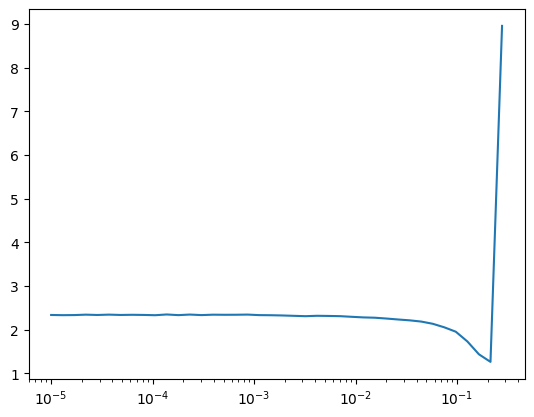

In [55]:
MomentumLearner(model, 
                data_loaders, 
                F.cross_entropy, 
                callbacks=[DeviceCallback()]).find_lr()

In [56]:
# Set the random seed for reproducibility
set_seed(42)

# Create a MomentumLearner instance with the initialized model
learn = MomentumLearner(create_cnn_model().apply(initialize_conv_weights),
                        data_loaders, 
                        F.cross_entropy, 
                        learning_rate=0.2, 
                        callbacks=cbs)

accuracy,loss,epoch,train
0.276,2.081,0,train
0.477,1.328,0,eval
0.712,0.812,1,train
0.798,0.547,1,eval
0.828,0.470,2,train
0.807,0.508,2,eval


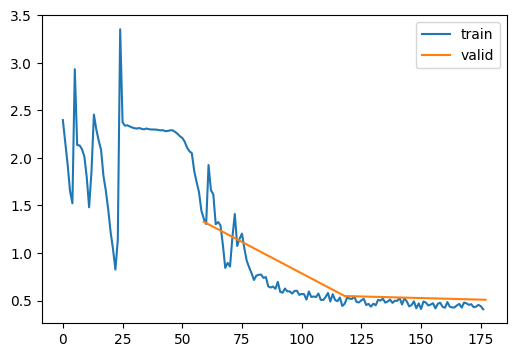

In [57]:
learn.fit(3)

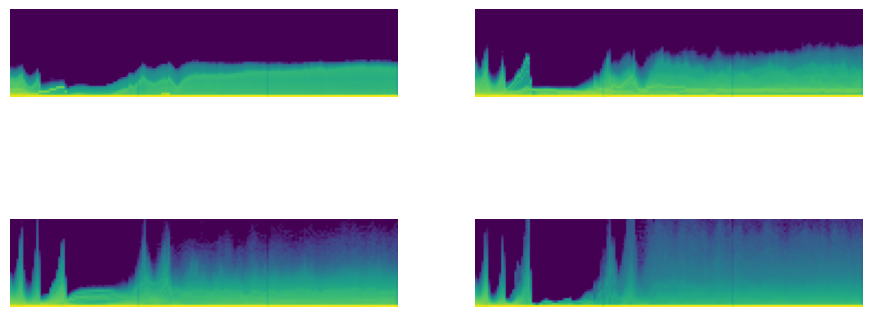

In [58]:
astats.plot_color_dimensions()

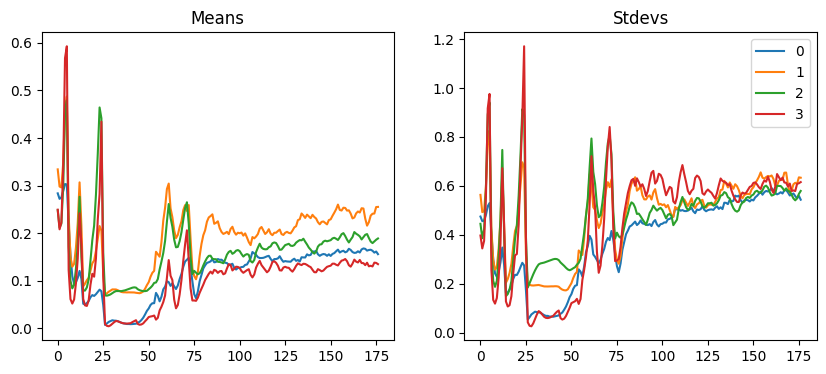

In [59]:
astats.plot_activation_stats()

## Input normalization

In [60]:
# Calculate the mean and standard deviation of the inputs_batch
inputs_mean, inputs_std = inputs_batch.mean(), inputs_batch.std()

# Print the calculated mean and standard deviation
inputs_mean, inputs_std

(tensor(0.29), tensor(0.35))

In [61]:
#|export
class BatchTransformCallback(Callback):
    def __init__(self, transform, apply_on_train=True, apply_on_val=True):
        """
        Callback to apply a transformation `transform` to batches during training and/or validation.

        Args:
        - transform: The transformation function to apply to batches.
        - apply_on_train: Whether to apply the transformation during training batches.
        - apply_on_val: Whether to apply the transformation during validation batches.
        """
        self.transform = transform
        self.apply_on_train = apply_on_train
        self.apply_on_val = apply_on_val

    def before_batch(self, learn):
        """
        Apply the transformation to the batch before each training or validation batch if the corresponding flag is True.
        """
        if (self.apply_on_train and learn.training) or (self.apply_on_val and not learn.training):
            learn.batch = self.transform(learn.batch)

In [62]:
def normalize_batch(batch):
    """
    Normalize the input batch `batch` using the pre-calculated mean `xmean` and standard deviation `xstd`.

    Args:
    - batch: The input batch to be normalized.

    Returns:
    - Tuple: A tuple containing the normalized input batch and the original labels from the batch.
    """
    return (batch[0] - inputs_mean) / inputs_std, batch[1]

# Create a BatchTransformCallback instance for normalization
normalization_callback = BatchTransformCallback(normalize_batch)

accuracy,loss,epoch,train
0.497,1.508,0,train
0.734,0.722,0,eval
0.809,0.521,1,train
0.819,0.485,1,eval
0.844,0.424,2,train
0.828,0.462,2,eval


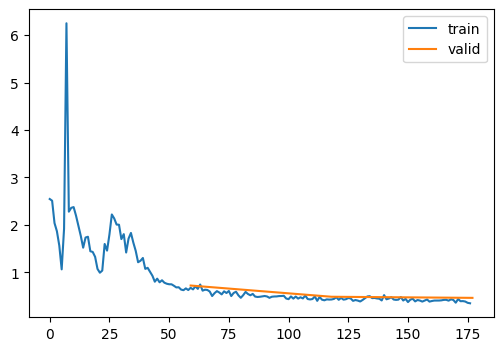

In [63]:
set_seed(42)
learn = MomentumLearner(create_cnn_model().apply(initialize_conv_weights), 
                        data_loaders, 
                        F.cross_entropy, 
                        learning_rate=0.2, 
                        callbacks=cbs+[normalization_callback])
learn.fit(3)

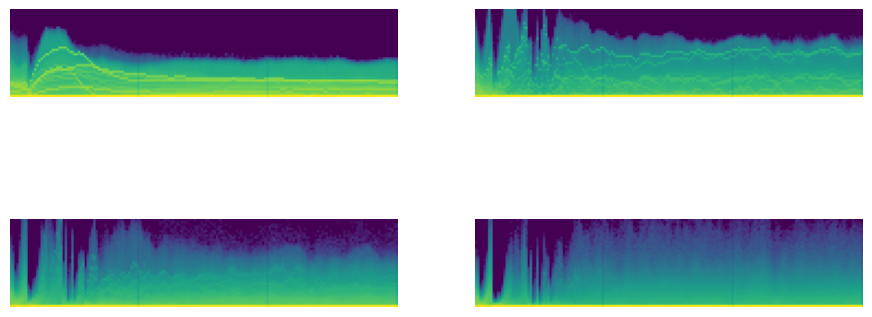

In [64]:
astats.plot_color_dimensions()

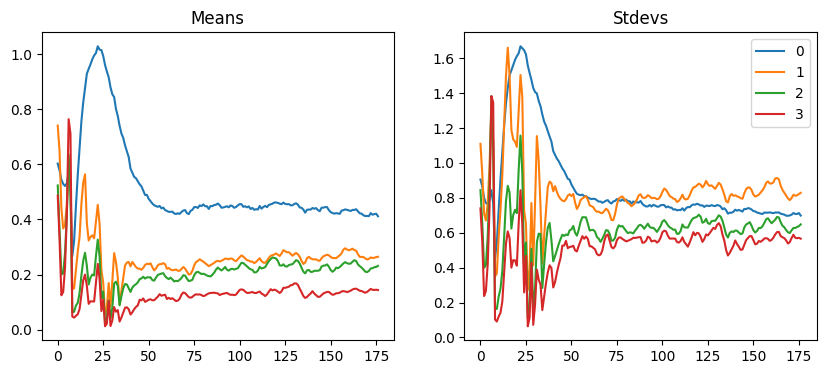

In [65]:
astats.plot_activation_stats()

In [66]:
# Define the function to transform the data inplace
@apply_inplace_transformation
def transform_images_inplace(batch):
    """
    Transform the images in the batch to tensors and flatten them inplace.

    Args:
    - batch (dict): A dictionary containing the batch of data.

    Returns:
    - dict: The transformed batch with images flattened as tensors.
    """
    batch[image_key] = [(TF.to_tensor(image) - inputs_mean) / inputs_std for image in batch[image_key]]
    return batch

# Apply the transform function `transform_images_inplace` to the dataset `loaded_dataset`
transformed_dataset = dataset_dict.with_transform(transform_images_inplace)

# Create data loaders from the transformed dataset `transformed_dataset` with the specified batch size `batch_size` and number of workers `num_workers`
data_loaders = DataLoaders.from_dataset_dict(transformed_dataset, batch_size, num_workers=4)

# Get the training data loader from the created data loaders
train_data_loader = data_loaders.train_loader

# Get a batch of data from the training data loader
inputs_batch, labels_batch = next(iter(train_data_loader))

In [67]:
inputs_batch.mean(), inputs_batch.std()

(tensor(0.01), tensor(1.00))

## General ReLU

In [68]:
#|export
class GeneralRelu(nn.Module):
    def __init__(self, negative_slope=None, subtract=None, max_value=None):
        """
        Custom implementation of a Rectified Linear Unit (ReLU) activation function with additional features.

        Args:
        - negative_slope (float, optional): The slope for the negative part of the function (leaky ReLU). If None, regular ReLU is used. Default: None.
        - subtract (float, optional): A value to subtract from the output tensor after applying the activation function. Default: None.
        - max_value (float, optional): The maximum value to clamp the output tensor. Values above this threshold will be set to max_value. Default: None.
        """
        super().__init__()
        self.negative_slope = negative_slope
        self.subtract = subtract
        self.max_value = max_value

    def forward(self, x): 
        """
        Forward pass through the Generalized ReLU activation function.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after applying the activation function.
        """
        if self.negative_slope is not None:
            x = F.leaky_relu(x, negative_slope=self.negative_slope)
        else:
            x = F.relu(x)
        if self.subtract is not None:
            x -= self.subtract
        if self.max_value is not None:
            x = torch.clamp_max(x, max=self.max_value)
        return x

In [69]:
#|export
def plot_function(function, start=-5., end=5., steps=100):
    """
    Plot the graph of a given function within a specified range.

    Args:
    - function (callable): The function to be plotted.
    - start (float, optional): The starting point of the range for the x-axis. Default: -5.0.
    - end (float, optional): The ending point of the range for the x-axis. Default: 5.0.
    - steps (int, optional): The number of steps to use for plotting. Default: 100.
    """
    x = torch.linspace(start, end, steps)
    plt.plot(x, function(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

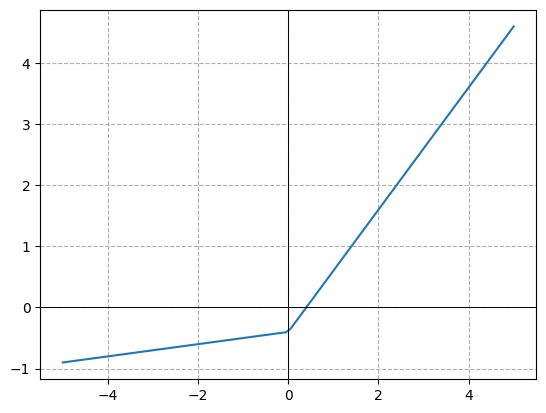

In [70]:
plot_function(GeneralRelu(negative_slope=0.1, subtract=0.4))

In [71]:
def convolution_layer(in_channels, out_channels, kernel_size=3, stride=2, activation=nn.ReLU):
    """
    Create a convolutional layer with optional activation.

    Args:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - kernel_size (int, optional): Size of the convolutional kernel. Default: 3.
    - stride (int, optional): Stride for the convolution. Default: 2.
    - activation (torch.nn.Module, optional): Activation function to apply. Default: nn.ReLU.

    Returns:
    - torch.nn.Module: Convolutional layer with optional activation.
    """
    layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2)
    if activation:
        layer = nn.Sequential(layer, activation())
    return layer

In [72]:
def get_model(activation=nn.ReLU, num_filters=None):
    """
    Create a convolutional neural network model.

    Args:
    - activation (torch.nn.Module, optional): Activation function to use. Default: nn.ReLU.
    - num_filters (list of int, optional): Number of filters for each layer. Default: [1, 8, 16, 32, 64].

    Returns:
    - torch.nn.Sequential: Convolutional neural network model.
    """
    if num_filters is None:
        num_filters = [1, 8, 16, 32, 64]

    layers = [convolution_layer(num_filters[i], num_filters[i + 1], activation=activation) for i in range(len(num_filters) - 1)]
    return nn.Sequential(*layers, convolution_layer(num_filters[-1], 10, activation=None), nn.Flatten()).to(default_device)

In [73]:
#|export
def initialize_conv_weights(module, leaky=0.):
    """
    Initialize the weights of convolutional layers using Kaiming normal initialization.
    
    Args:
    - module (nn.Module): The module for which to initialize weights.
    """
    if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        init.kaiming_normal_(module.weight, a=leaky)

In [74]:
act_config = partial(GeneralRelu, negative_slope=0.1, subtract=0.4)
activation_stats = ActivationStatisticsCallback(fc.risinstance(GeneralRelu))
callbacks = [DeviceCallback(), metrics, ProgressCallback(plot=True), activation_stats]
initialize_weights = partial(initialize_conv_weights, leaky=0.1)

In [75]:
model = get_model(act_config).apply(initialize_weights)

accuracy,loss,epoch,train
0.743,0.759,0,train
0.846,0.435,0,eval
0.866,0.367,1,train
0.866,0.369,1,eval
0.881,0.324,2,train
0.871,0.354,2,eval


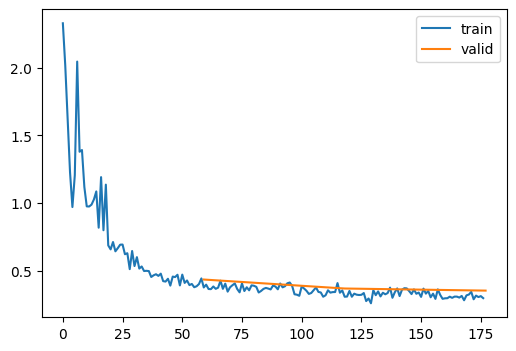

In [76]:
set_seed(42)
learn = MomentumLearner(model, data_loaders, F.cross_entropy, learning_rate=0.2, callbacks=callbacks)
learn.fit(3)

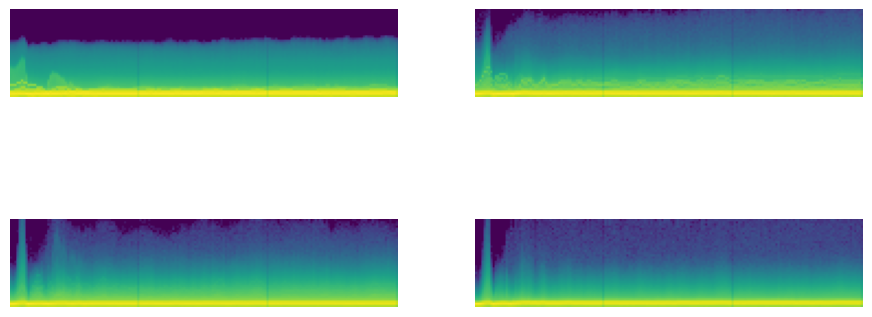

In [77]:
activation_stats.plot_color_dimensions()

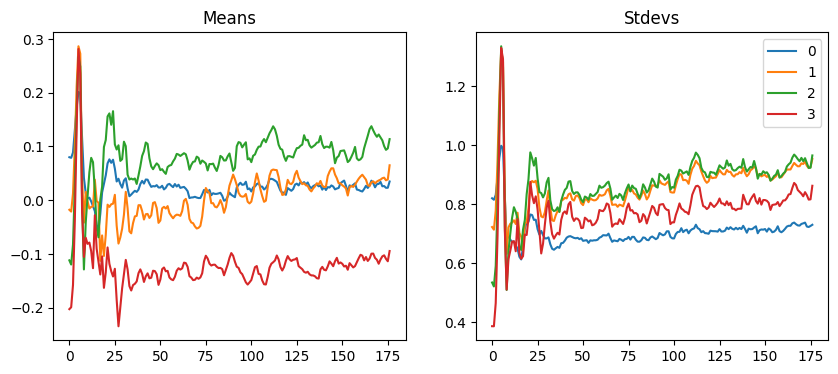

In [78]:
activation_stats.plot_activation_stats()

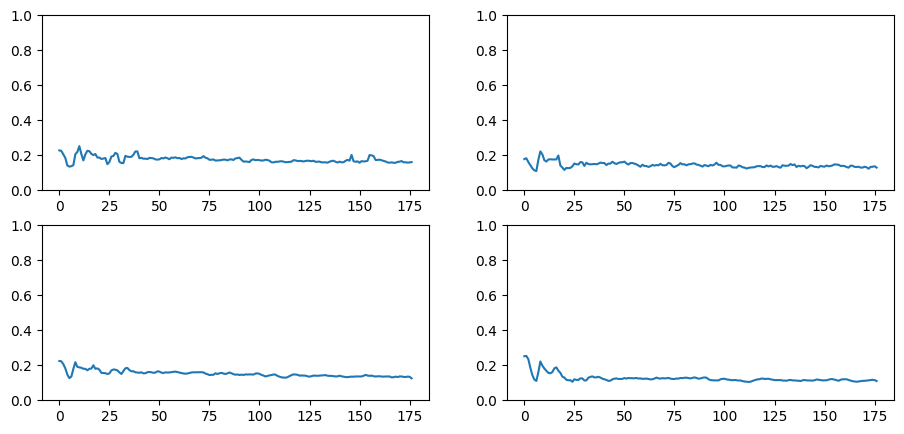

In [79]:
activation_stats.plot_dead_neurons()

## LSUV

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces *Layer-wise Sequential Unit-Variance* (*LSUV*).

In [80]:
#|export
def _lsuv_stats(hook, module, input, output):
    # Calculate the mean and standard deviation of the activations
    activations = to_cpu(output)
    hook.activation_mean = activations.mean()
    hook.activation_std = activations.std()

def lsuv_init(model, layer, layer_input, input_batch):
    # Initialize the LSUV algorithm
    activation_hook = Hook(layer, _lsuv_stats)
    with torch.no_grad():
        # Adjust the weights and biases until the mean and standard deviation of the activations are close to 0 and 1 respectively
        while model(input_batch) is not None and (abs(activation_hook.activation_std - 1) > 1e-3 or abs(activation_hook.activation_mean) > 1e-3):
            layer_input.bias -= activation_hook.activation_mean
            layer_input.weight.data /= activation_hook.activation_std
    # Remove the activation hook
    activation_hook.remove()

In [81]:
model = get_model(act_config)
relu_modules = [module for module in model.modules() if isinstance(module, GeneralRelu)]
conv_modules = [module for module in model.modules() if isinstance(module, nn.Conv2d)]

In [82]:
for modules in zip(relu_modules, conv_modules):
    print(modules)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [83]:
for modules in zip(relu_modules, conv_modules):
    lsuv_init(model, *modules, inputs_batch.to(default_device))

accuracy,loss,epoch,train
0.769,0.658,0,train
0.833,0.457,0,eval
0.862,0.378,1,train
0.854,0.401,1,eval
0.876,0.336,2,train
0.862,0.376,2,eval


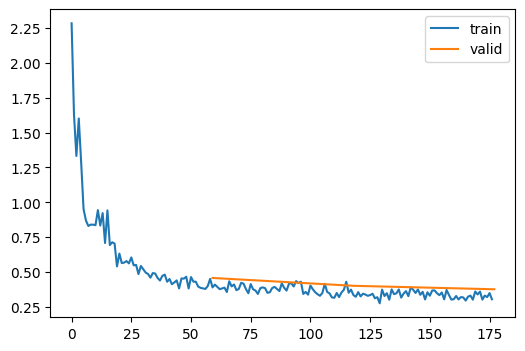

In [84]:
set_seed(42)
learn = MomentumLearner(model, 
                        data_loaders, 
                        F.cross_entropy, 
                        learning_rate=0.2, 
                        callbacks=callbacks)
learn.fit(3)

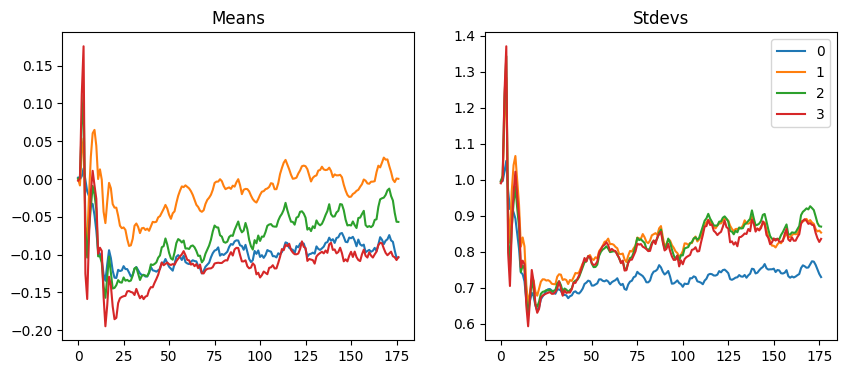

In [85]:
activation_stats.plot_activation_stats()

## Batch Normalization

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

### LayerNorm

We'll start with [layer normalization](https://arxiv.org/abs/1607.06450), a simpler technique.

In [86]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
        self.scale = nn.Parameter(torch.tensor(1.))
        self.bias = nn.Parameter(torch.tensor(0.))

    def forward(self, x):
        mean = x.mean((1, 2, 3), keepdim=True)
        variance = x.var((1, 2, 3), keepdim=True)
        x = (x - mean) / torch.sqrt(variance + self.epsilon)
        return x * self.scale + self.bias

In [87]:
#|export
def conv_layer(input_channels, output_channels, kernel_size=3, stride=2, activation=nn.ReLU, normalization=None, use_bias=None):
    """
    Create a convolutional layer with optional activation and normalization.

    Args:
    - input_channels (int): Number of input channels.
    - output_channels (int): Number of output channels.
    - kernel_size (int): Size of the convolutional kernel.
    - stride (int): Stride of the convolution operation.
    - activation (torch.nn.Module): Activation function to use.
    - normalization (torch.nn.Module): Normalization layer to apply.
    - use_bias (bool): Whether to use bias in the convolutional layer.

    Returns:
    - torch.nn.Module: Convolutional layer with optional activation and normalization.
    """
    if use_bias is None:
        use_bias = not isinstance(normalization, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    
    layers = [
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=use_bias)
    ]
    if normalization:
        layers.append(normalization(output_channels))
    if activation:
        layers.append(activation())
    
    return nn.Sequential(*layers)

In [88]:
#|export
def get_model(activation=nn.ReLU, num_filters=None, normalization=None):
    """
    Create a convolutional neural network model using the specified activation, number of filters, and normalization.

    Args:
    - activation (torch.nn.Module): Activation function to use.
    - num_filters (list): List of integers specifying the number of filters for each convolutional layer.
    - normalization (torch.nn.Module): Normalization layer to apply.

    Returns:
    - torch.nn.Module: Convolutional neural network model.
    """
    if num_filters is None:
        num_filters = [1, 8, 16, 32, 64]
    
    layers = [
        conv_layer(num_filters[i], num_filters[i+1], activation=activation, normalization=normalization)
        for i in range(len(num_filters)-1)
    ]
    return nn.Sequential(
        *layers,
        conv_layer(num_filters[-1], 10, activation=None, normalization=None, use_bias=True),
        nn.Flatten()
    ).to(default_device)

accuracy,loss,epoch,train
0.788,0.583,0,train
0.839,0.439,0,eval
0.865,0.368,1,train
0.860,0.377,1,eval
0.879,0.328,2,train
0.854,0.398,2,eval


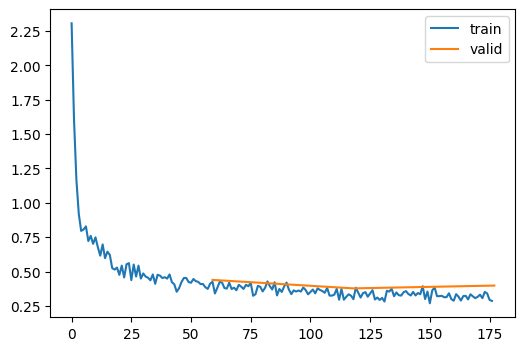

In [89]:
set_seed(42)
model = get_model(act_config, normalization=LayerNorm).apply(initialize_weights)
learn = MomentumLearner(model, data_loaders, F.cross_entropy, learning_rate=0.2, callbacks=callbacks)
learn.fit(3)

### BatchNorm

In [90]:
class BatchNorm(nn.Module):
    """
    Batch normalization layer.

    Args:
    - nf (int): Number of input features.
    - mom (float): Momentum for updating running mean and variance.
    - eps (float): Small value to avoid division by zero.

    Attributes:
    - mom (float): Momentum for updating running mean and variance.
    - eps (float): Small value to avoid division by zero.
    - scale (torch.nn.Parameter): Scaling parameters.
    - bias (torch.nn.Parameter): Bias parameters.
    - running_variance (torch.Tensor): Running variance.
    - running_mean (torch.Tensor): Running mean.

    Methods:
    - update_stats(inputs): Update running mean and variance with the input tensor x.
    - forward(x): Forward pass through the batch normalization layer.
    """
    def __init__(self, num_features, momentum=0.1, epsilon=1e-5):
        super().__init__()
        self.momentum = momentum
        self.epsilon = epsilon
        self.scale = nn.Parameter(torch.ones(num_features, 1, 1))
        self.bias = nn.Parameter(torch.zeros(num_features, 1, 1))
        self.register_buffer('running_variance', torch.ones(1, num_features, 1, 1))
        self.register_buffer('running_mean', torch.zeros(1, num_features, 1, 1))

    def update_stats(self, inputs):
        """
        Update running mean and variance with the input tensor.

        Args:
        - inputs (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Updated running mean.
        - torch.Tensor: Updated running variance.
        """
        mean = inputs.mean((0, 2, 3), keepdim=True)
        variance = inputs.var((0, 2, 3), keepdim=True)
        self.running_mean.lerp_(mean, self.momentum)
        self.running_variance.lerp_(variance, self.momentum)
        return mean, variance

    def forward(self, inputs):
        """
        Forward pass through the batch normalization layer.

        Args:
        - inputs (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after applying batch normalization.
        """
        if self.training:
            with torch.no_grad():
                mean, variance = self.update_stats(inputs)
        else:
            mean, variance = self.running_mean, self.running_variance
        normalized_inputs = (inputs - mean) / torch.sqrt(variance + self.epsilon)
        return normalized_inputs * self.scale + self.bias

accuracy,loss,epoch,train
0.794,0.570,0,train
0.832,0.493,0,eval
0.872,0.346,1,train
0.866,0.363,1,eval
0.886,0.310,2,train
0.871,0.345,2,eval


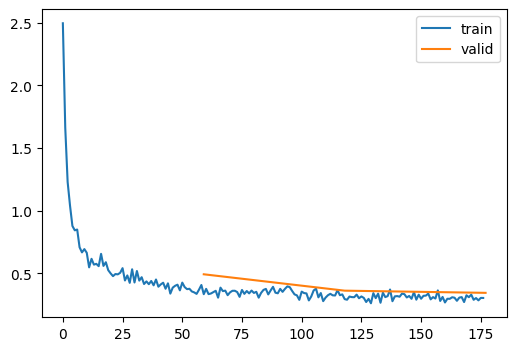

In [91]:
model = get_model(act_config, normalization=BatchNorm).apply(initialize_weights)
set_seed(42)
learn = MomentumLearner(model, data_loaders, F.cross_entropy, learning_rate=0.4, callbacks=callbacks)
learn.fit(3)

![Various norms](images/norms.png)

## Towards 90%...

In [92]:
# Create data loaders from the transformed dataset `transformed_dataset` with the specified batch size `batch_size` and number of workers `num_workers`
data_loaders = DataLoaders.from_dataset_dict(transformed_dataset, 256, num_workers=4)

accuracy,loss,epoch,train
0.835,0.450,0,train
0.865,0.373,0,eval
0.880,0.323,1,train
0.877,0.346,1,eval
0.892,0.292,2,train
0.857,0.408,2,eval


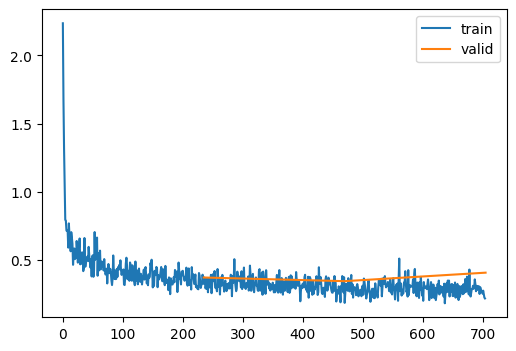

In [93]:
set_seed(42)
model = get_model(act_config, normalization=nn.BatchNorm2d).apply(initialize_weights)
learn = MomentumLearner(model, data_loaders, F.cross_entropy, learning_rate=0.2, callbacks=callbacks)
learn.fit(3)

accuracy,loss,epoch,train
0.911,0.239,0,train
0.895,0.286,0,eval


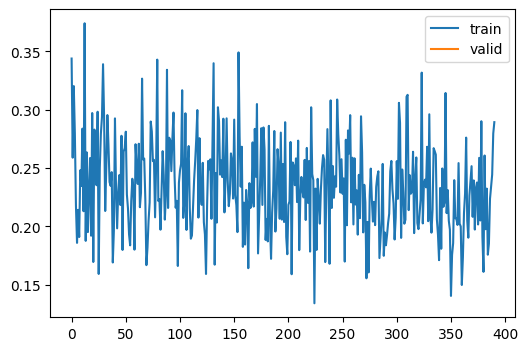

In [ ]:
learn = MomentumLearner(model, data_loaders, F.cross_entropy, learning_rate=0.05, callbacks=callbacks)
learn.fit(2)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()